# 神经网络基本原理-2

## 1 梯度下降法

## 2 分类算法

本小节介绍逻辑分类模型的原理。


### 2.1 生成样本数据


逻辑回归模型

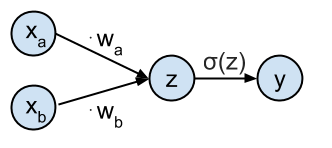

目标值: $\mathbf{t}\in R^{N\times 1}$ 

样本数据：$\mathbf{x}\in R^{N\times 2}$

数据点（二维）：$\mathbf{x}_i=[x_{1i},x_{2i}]$ 

In [2]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np  
import matplotlib
import matplotlib.pyplot as plt  
from matplotlib import cm 
from matplotlib.colors import colorConverter, ListedColormap
import seaborn as sns  

sns.set_style('darkgrid')
np.random.seed(seed=1)


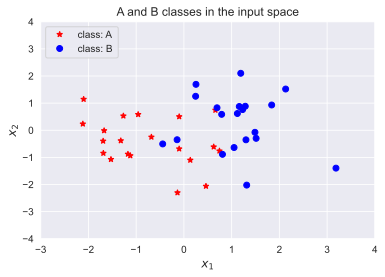

In [3]:
# 生成样本数据
Na_samples,  Nb_samples = 20, 20   # a类和b类数据的个数
a_mean = (-1., 0.)  # a类型的平均值
b_mean = (1., 0.)  # b类型的平均值
# 生成样本数据
x_a  = np.random.randn(Na_samples, 2) + a_mean
x_b = np.random.randn(Nb_samples, 2)  + b_mean

# 合并数据，假设预先不知分类情况
X = np.vstack((x_a, x_b))
t = np.vstack((np.zeros((Na_samples,1)), 
               np.ones((Nb_samples,1))))
#
# Plot both classes on the x1, x2 plane
plt.figure(figsize=(6, 4))
plt.plot(x_a[:,0], x_a[:,1], 'r*', label='class: A ')
plt.plot(x_b[:,0], x_b[:,1], 'bo', label='class: B')
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-3, 4, -4, 4])
plt.title('A and B classes in the input space')
plt.show()
#

### 2.2 逻辑函数与交叉熵损失函数 

### 2.2.1 逻辑函数

![ANN1](./14-L7-Neural-network/SimpleANN02.png)

目的： 预测数据点$\mathbf{x}_i$属于类型$t_i$的概率$P(t_i=1|\mathbf{x}_i,\mathbf{w})$

神经网络：

--输入量$\mathbf{x}_i=[x_{1i},x_{2i}]$

--权重：$\mathbf{w}=[w_{1},w_{2}]$

--预测结果：$y_i=\sigma(\mathbf{x}_i\cdot \mathbf{w}^\mathrm{T})$

逻辑函数定义为
$$
\sigma=\frac{1}{1+\mathrm{e}^{-z}}
$$


### 2.2.2 交叉熵损失函数

逻辑预测模型的损失函数采用交叉熵误差函数，对于样本$i$，交叉熵误差为
$$
L(t_i,y_i) = -t_i \log y_i -(1-t_i) \log(1- y_i)
$$
对于所有样本的损失函数为：
$$
L(\mathbf{t},\mathbf{y}) = -\frac{1}{N}\sum_{i=1}^{N}[t_i \log y_i +(1-t_i) \log(1- y_i)]
$$


In [6]:
# 逻辑函数
def logistic(z): 
    return 1. / (1 + np.exp(-z))

# 神经网络函数
#  y = 1 / (1 + numpy.exp(-x*w))
def nn_logit(x, w): 
    return logistic(x.dot(w.T))

# 神经网络预测函数，返回0或者1 
def nn_logit_predict(x,w): 
    return np.around(nn_logit(x,w))
    
# 损失函数
def loss_logit(y, t):
    return - np.mean(
        np.multiply(t, np.log(y)) + np.multiply((1-t), np.log(1-y)))

/var/folders/_g/qrb_wrl10t355t8pxv072fqh0000gn/T/ipykernel_30266/2051660577.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


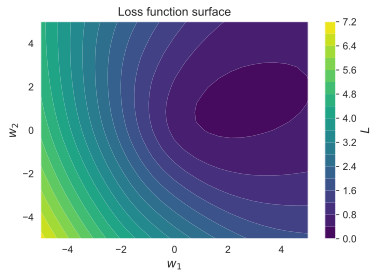

In [7]:
# 绘制损失函数与二维参数的关系
# 参数的范畴
Nw1,Nw2 = 25, 25 # 两个维度的网格数
wsa = np.linspace(-5, 5, num=Nw1) # 权重 a
wsb = np.linspace(-5, 5, num=Nw2) # 权重 a
ws_x, ws_y = np.meshgrid(wsa, wsb) # 定义二维网格
loss_ws = np.zeros((Nw1, Nw2)) # 损失函数矩阵,2维
# 给定权重范畴内，计算损失韩式 
for i in range(Nw1):
    for j in range(Nw2):
        loss_ws[i,j] = loss_logit(nn_logit(X, np.asmatrix([ws_x[i,j], ws_y[i,j]])) , t)
# Plot the loss function surface
plt.figure(figsize=(6, 4))
plt.contourf(ws_x, ws_y, loss_ws, 20, cmap=cm.viridis)
cbar = plt.colorbar()
cbar.ax.set_ylabel('$L$', fontsize=12)
plt.xlabel('$w_1$', fontsize=12)
plt.ylabel('$w_2$', fontsize=12)
plt.title('Loss function surface')
plt.grid()
plt.show()
#

### 2.2.2 梯度下降法
目的：利用梯度下降法，迭代修正权重$\mathbf{w}$，直至损失函数的全局极小值。

$$
\mathbf{w}(k+1)=\mathbf{w}(k)-\Delta\mathbf{w}(k)=\mathbf{w}(k)-\eta \frac{\partial L}{\partial \mathbf{w}}
$$


#### 2.2.2.1 链式求导法则

交叉熵损失函数对权重$\mathbf{w}$的倒数为
$$
\frac{\partial L_i}{\partial\mathbf{w}}=\frac{\partial L_i}{\partial y_i}\frac{\partial y_i}{\partial z_i}\frac{ \partial z_i}{\partial \mathbf{w}}
$$
其中，$y_i=\sigma(z_i)$和$z_i=\mathbf{x}_i\cdot \mathbf{w}^T$是逻辑神经元的输出和输入。

\begin{align}
\frac{\partial L_i}{\partial y_i} &=-\left[\frac{t_i}{y_i}-\frac{1-t_i}{1-y_i}\right] = \frac{y_i-t_i}{y_i(1-y_i)} \\
\frac{\partial y_i}{\partial z_i} &= y_i(1-y_i) \\
\frac{\partial z_i}{\partial \mathbf{w}} &=\frac{\partial \mathbf{x}_i\cdot\mathbf{w} }{\partial \mathbf{w}} = \mathbf{x}_i
\end{align}

代入以上结果可得，
$$
\frac{\partial L_i}{\partial\mathbf{w}}=\frac{\partial L_i}{\partial y_i}\frac{\partial y_i}{\partial z_i}\frac{ \partial z_i}{\partial \mathbf{w}} = \mathbf{x}_i(y_i-t_i)
$$
因此，权重修正为，
$$
\Delta\mathbf{w} = \eta\frac{1}{N}\sum_{i=1}^N\mathbf{x}_i(y_i-t_i)
$$

In [9]:
def gradient(w, x, t):
    """梯度函数"""
    return (nn_logit(x, w) - t).T * x

 
def delta_w(w_k, x, t, eta):
    """Update function which returns the update for each 
    weight {w_a, w_b} in a vector."""
    return eta * gradient(w_k, x, t)

#### 2.2.2.2 权重迭代修正

绘制损失函数与权重的关系

/var/folders/_g/qrb_wrl10t355t8pxv072fqh0000gn/T/ipykernel_30266/1934016055.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


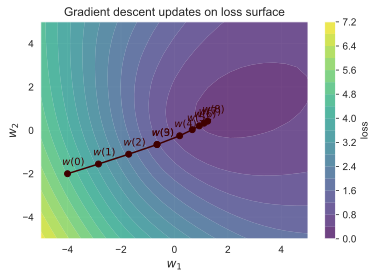

In [13]:
# 设定权重初始值，随机猜测
w = np.asmatrix([-4, -2])  # Randomly decided
# 学习率
eta = 0.03


N_iter = 10  # 迭代次数
w_iter = [w]  # 
for i in range(N_iter):
    dw = delta_w(w, X, t, eta)  
    w = w - dw  
    w_iter.append(w)  
    

plt.figure(figsize=(6, 4))
plt.contourf(ws_x, ws_y, loss_ws, 20, alpha=0.75, cmap=cm.viridis)
cbar = plt.colorbar()
cbar.ax.set_ylabel('loss')

# 绘制权重的位置
for i in range(1, N_iter): 
    w1 = w_iter[i-1]
    w2 = w_iter[i]
    plt.plot(w1[0,0], w1[0,1], marker='o', color='#3f0000')  
    plt.plot([w1[0,0], w2[0,0]], [w1[0,1], w2[0,1]], linestyle='-', color='#3f0000')
    plt.text(w1[0,0]-0.2, w1[0,1]+0.4, f'$w({i-1})$', color='#3f0000')

w1 = w_iter[3]  
plt.plot(w1[0,0], w1[0,1], marker='o', color='#3f0000')
plt.text(w1[0,0]-0.2, w1[0,1]+0.4, f'$w({i})$', color='#3f0000') 
plt.xlabel('$w_1$', fontsize=12)
plt.ylabel('$w_2$', fontsize=12)
plt.title('Gradient descent updates on loss surface')
plt.show()

In [7]:
#### 2.2.2.3 分类结果可视化



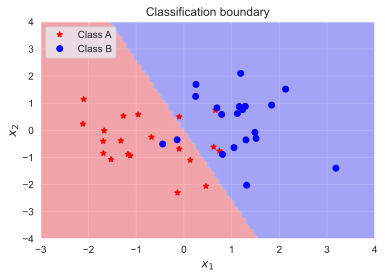

In [12]:
# 绘制决策边界
plt.figure(figsize=(6, 4))

nb_of_xs = 100
xsa = np.linspace(-4, 4, num=nb_of_xs)
xsb = np.linspace(-4, 4, num=nb_of_xs)
xx, yy = np.meshgrid(xsa, xsb) 

classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        classification_plane[i,j] = nn_logit_predict(
            np.asmatrix([xx[i,j], yy[i,j]]) , w)
# Create a color map to show the classification space
cmap = ListedColormap([
        colorConverter.to_rgba('r', alpha=0.3),
        colorConverter.to_rgba('b', alpha=0.3)])

# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
plt.plot(x_a[:,0], x_a[:,1], 'r*', label='Class A')
plt.plot(x_b[:,0], x_b[:,1], 'bo', label='Class B')
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.title('Classification boundary')
plt.axis([-3, 4, -4, 4])
plt.show()
#